In [ ]:
 import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, concatenate, Lambda, BatchNormalization, Dropout
from tensorflow.keras import Sequential, Model
import traceback as tb
from tensorflow.keras.losses import CosineSimilarity

In [ ]:
!wget -c https://www.dropbox.com/s/ee5rwju5qnlrxb4/sign_data_2.zip

--2021-01-31 02:55:56--  https://www.dropbox.com/s/ee5rwju5qnlrxb4/sign_data_2.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ee5rwju5qnlrxb4/sign_data_2.zip [following]
--2021-01-31 02:55:56--  https://www.dropbox.com/s/raw/ee5rwju5qnlrxb4/sign_data_2.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc9caece27dc6d3bc9a478140fd.dl.dropboxusercontent.com/cd/0/inline/BIA2kQGiZ4MTHa4oXexZv8JqHL6phovhbUdgpPibUUHbyLNrDx6cGY4iXbizCLRbfsn21zaUg9JEFInun6a4sd5rOUEZ-q5Srb_c1BZJ6-oXJFjqd49Nc-KNo5DYwI5SzSQ/file# [following]
--2021-01-31 02:55:56--  https://ucc9caece27dc6d3bc9a478140fd.dl.dropboxusercontent.com/cd/0/inline/BIA2kQGiZ4MTHa4oXexZv8JqHL6phovhbUdgpPibUUHbyLNrDx6cGY4iXbizCLRbfsn21zaUg9JEFInun6a4sd5rOUEZ-q5Srb_c1B

In [ ]:
!unzip -uq sign_data_2.zip

In [ ]:
train_dir = '/content/sign_data_2/train'
test_dir = '/content/sign_data_2/test'

The following is a generator function which yields (or "returns") a data point at a time. A data point consists of 3 images (anchor, positive and negative) and a dummy label that needs to be fed to tenorflow model.

In [ ]:
def preprocess(image):
  kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))   # defining kernel for mathematical morphing
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   # converting to gray scale
  thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] # converting to black and white image
  thresh = cv2.erode(thresh, kernel, iterations=3)   # performing erosion operation 
  thresh = cv2.dilate(thresh, kernel, iterations=1)  # performing dilation 
  image = cv2.resize(thresh, (250, 75))             # resizing
  return image

def train_data_gen():
    '''
    A generator function which yields one training data point at a time.
    '''
    for folder in os.listdir(train_dir):
        '''
        Setting paths for real1,real2,forge folders 
        '''
        real1 = os.path.join(train_dir, folder, '1')
        real2 = os.path.join(train_dir, folder, '2')
        forge = os.path.join(train_dir, folder, 'forg')
        
        for r2 in os.listdir(real2):
            
            r2_path = os.path.join(real2,r2)
            
            try:
                r2_img = cv2.imread(r2_path,cv2.IMREAD_COLOR)     # reading image
                r2_img = preprocess(r2_img)

            except Exception as ex:
                print(r2_path)
                tb.print_tb(ex.__traceback__)
            
            for r1,f in zip(os.listdir(real1), os.listdir(forge)):
                
                r1_path = os.path.join(real1,r1)
                f_path = os.path.join(forge,f)

                try:
                    r1_img = cv2.imread(r1_path,cv2.IMREAD_COLOR)    # reading image
                    r1_img = preprocess(r1_img)

                except Exception as ex:
                    print(r1_path)
                    tb.print_tb(ex.__traceback__)

                try:
                    f_img = cv2.imread(f_path,cv2.IMREAD_COLOR)     # reading image
                    f_img = preprocess(f_img)

                except Exception as ex:
                    print(f_path)
                    tb.print_tb(ex.__traceback__)
                
                r1_img_arr = np.expand_dims(np.array(r1_img), axis=-1)  # reshaping to (75,250,1)
                assert r1_img_arr.shape == (75, 250, 1)
                r2_img_arr = np.expand_dims(np.array(r2_img), axis=-1)
                assert r2_img_arr.shape == (75, 250, 1)
                f_img_arr = np.expand_dims(np.array(f_img), axis=-1)
                assert f_img_arr.shape == (75, 250, 1)
                yield (r1_img_arr, r2_img_arr, f_img_arr), 1


In [ ]:
train_gen = train_data_gen()

In [ ]:
# train_data.shape

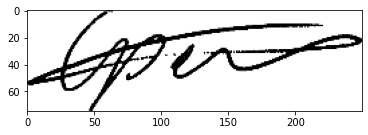

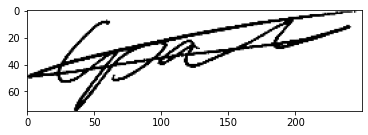

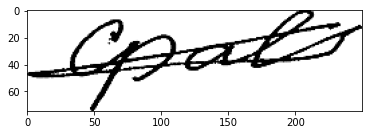

Number of training samples: 3252


In [ ]:
train_example = next(train_gen)
for i in [0,1,2]:
    plt.imshow(train_example[0][i].reshape(75, 250),cmap='gray')
    plt.show()

train_gen_list = list(train_gen)
print('Number of training samples:', len(train_gen_list) + 1)
del train_gen, train_gen_list

The following cell constructs a tensorflow data structure called Dataset from training data generator function for compatibility with tensorflow.

In [ ]:
train_dataset = tf.data.Dataset.from_generator(
    train_data_gen,
    output_signature=(
            (tf.TensorSpec((75, 250, 1), tf.int32),
             tf.TensorSpec((75, 250, 1), tf.int32),
             tf.TensorSpec((75, 250, 1), tf.int32)),
            tf.TensorSpec((), tf.int32)
         )
)
train_dataset = train_dataset.shuffle(3252, reshuffle_each_iteration=True)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(64)

The following function is a generator function for test data similar to `train_data_gen` above. Here also a data point consists of 3 images (anchor, positive and negative) and a dummy label.

In [ ]:
def test_data_gen():
    '''
    A generator function which yields one test data point at a time.
    '''
    for folder in os.listdir(test_dir):
        '''
        Setting paths for real1,real2,forge folders 
        '''
        real1 = os.path.join(test_dir, folder, '1')
        real2 = os.path.join(test_dir, folder, '2')
        forge = os.path.join(test_dir, folder, 'forg')

        for r2 in os.listdir(real2):

            r2_path = os.path.join(real2, r2)   # r2 image path

            kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))

            try:
                r2_img = cv2.imread(r2_path,cv2.IMREAD_COLOR)     # reading image
                gray = cv2.cvtColor(r2_img, cv2.COLOR_BGR2GRAY)   # converting to gray scale
                thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] # converting to black and white image
                thresh = cv2.erode(thresh, kernel, iterations=3)   # performing erosion operation 
                thresh = cv2.dilate(thresh, kernel, iterations=1)  # performing dilation 
                r2_img = cv2.resize(thresh, (250, 75))             # resizing

            except Exception as ex:
                print(r2_path)
                tb.print_tb(ex.__traceback__)
        
            for r1, f in zip(os.listdir(real1), os.listdir(forge)):
                
                r1_path = os.path.join(real1,r1)
                f_path = os.path.join(forge,f)
                
                try:
                    r1_img = cv2.imread(r1_path,cv2.IMREAD_COLOR)    # reading image
                    gray = cv2.cvtColor(r1_img, cv2.COLOR_BGR2GRAY)  # converting to gray scale
                    thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] # converting to black and white image
                    thresh = cv2.erode(thresh, kernel, iterations=3) # performing erosion operation 
                    thresh = cv2.dilate(thresh, kernel, iterations=1) # performing dilation 
                    r1_img = cv2.resize(thresh, (250, 75))            # resizing

                except Exception as ex:
                    print(r1_path)
                    tb.print_tb(ex.__traceback__)
                
                try:
                    f_img = cv2.imread(f_path,cv2.IMREAD_COLOR)     # reading image
                    gray = cv2.cvtColor(f_img, cv2.COLOR_BGR2GRAY)  # converting to gray scale
                    thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] # converting to black and white image
                    thresh = cv2.erode(thresh, kernel, iterations=3) # performing erosion operation 
                    thresh = cv2.dilate(thresh, kernel, iterations=1) # performing dilation 
                    f_img = cv2.resize(thresh, (250, 75))             # resizing

                except Exception as ex:
                    print(f_path)
                    tb.print_tb(ex.__traceback__)
                
                r1_img_arr = np.array(r1_img).reshape(75,250,1)  # reshaping to (75,250,1)
                assert r1_img_arr.shape == (75, 250, 1)
                r2_img_arr = np.array(r2_img).reshape(75,250,1)
                assert r2_img_arr.shape == (75, 250, 1)
                f_img_arr = np.array(f_img).reshape(75,250,1)
                assert f_img_arr.shape == (75, 250, 1)
                yield (r1_img_arr, r2_img_arr, f_img_arr), 1


In [ ]:
test_gen = test_data_gen()

In [ ]:
# test_data[0].shape

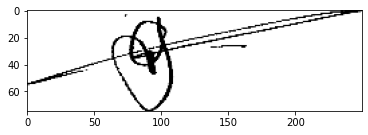

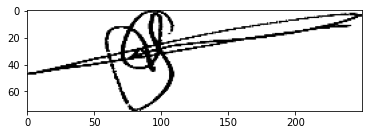

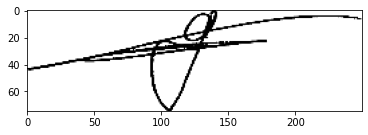

Number of testing/validation samples: 720


In [ ]:
test_example = next(test_gen)
for i in [0,1,2]:
    plt.imshow(test_example[0][i].reshape(75, 250),cmap='gray')
    plt.show()

test_gen_list = list(test_gen)
print('Number of testing/validation samples:', len(test_gen_list) + 1)
del test_gen, test_gen_list

In [ ]:
test_dataset = tf.data.Dataset.from_generator(
    test_data_gen,
    output_signature=(
            (tf.TensorSpec((75, 250, 1), tf.int32),
             tf.TensorSpec((75, 250, 1), tf.int32),
             tf.TensorSpec((75, 250, 1), tf.int32)),
            tf.TensorSpec((), tf.int32)
            )
    )

test_dataset = test_dataset.shuffle(720, reshuffle_each_iteration=True)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(64)

This is a base model to which all 3 images have to be fed

In [ ]:
base_network = Sequential(name='base_network')

base_network.add(Conv2D(64, (5, 5), activation='relu',kernel_initializer='he_normal', input_shape=(75, 250, 1)))
base_network.add(BatchNormalization())
base_network.add(MaxPool2D((2, 2),padding='same'))

base_network.add(Conv2D(128, (5, 5), activation='relu',kernel_initializer='he_normal'))
base_network.add(BatchNormalization())
base_network.add(MaxPool2D((2, 2),padding='same'))

base_network.add(Dropout(0.2))

base_network.add(Conv2D(256, (5, 5), activation='relu',kernel_initializer='he_normal'))
base_network.add(BatchNormalization())
base_network.add(MaxPool2D((2, 2),padding='same'))

base_network.add(Dropout(0.2))

base_network.add(Conv2D(256, (5, 5), activation='relu',kernel_initializer='he_normal'))
base_network.add(BatchNormalization())
base_network.add(MaxPool2D((2, 2),padding='same'))

base_network.add(Flatten())

base_network.add(Dense(1024, activation = 'relu'))
base_network.summary()

Model: "base_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 71, 246, 64)       1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 71, 246, 64)       256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 123, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 119, 128)      204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 119, 128)      512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 60, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 60, 128)      

Here we define our loss function. Tensorflow feeds both `y_true` and `y_pred` to the loss function. So our function should also accept those parameters but we ignore `y_true` as we don't need it for computation of loss.

We need our network to learn how to distinguish between genuine and forged signatures. So `anchor` and `positive` vectors need to be as close as possible and `anchor` and `negative` vectors need to be as distant as possible. That's why, we compute those distances. We need to punish the network if `pos_dist` is greater than `neg_dist` including the threshold. We don't need to do anything if the required threshold is already achieved. So we take max between 0 and the computed difference.


In [ ]:
def tf_triplet_loss(alpha):
    def triplet_loss(y_true, y_pred):
        anchor, positive, negative = tf.split(y_pred, 3, axis=-1)
        pos_dist = tf.math.squared_difference(anchor, positive)
        neg_dist = tf.math.squared_difference(anchor, negative)
        loss = tf.maximum(pos_dist - neg_dist + alpha, tf.zeros_like(pos_dist))
        return loss
    return triplet_loss

Cheking the positive and negative distance for few images before training the model.

In [ ]:
train_gen = train_data_gen()
img = next(train_gen)
print(np.array(img[0][0]).shape)
vec1 = base_network(np.expand_dims(img[0][0],axis=0))
vec2 = base_network(np.expand_dims(img[0][1],axis=0))
vec3 = base_network(np.expand_dims(img[0][2],axis=0))
pos_dist = tf.math.reduce_mean(tf.math.squared_difference(vec1, vec2))
neg_dist = tf.math.reduce_mean(tf.math.squared_difference(vec2, vec3))
print(pos_dist,neg_dist)

img = next(train_gen)
print(np.array(img[0][0]).shape)
vec1 = base_network(np.expand_dims(img[0][0],axis=0))
vec2 = base_network(np.expand_dims(img[0][1],axis=0))
vec3 = base_network(np.expand_dims(img[0][2],axis=0))
pos_dist = tf.math.reduce_mean(tf.math.squared_difference(vec1, vec2))
neg_dist = tf.math.reduce_mean(tf.math.squared_difference(vec2, vec3))
print(pos_dist,neg_dist)

img = next(train_gen)
print(np.array(img[0][0]).shape)
vec1 = base_network(np.expand_dims(img[0][0],axis=0))
vec2 = base_network(np.expand_dims(img[0][1],axis=0))
vec3 = base_network(np.expand_dims(img[0][2],axis=0))
pos_dist = tf.math.reduce_mean(tf.math.squared_difference(vec1, vec2))
neg_dist = tf.math.reduce_mean(tf.math.squared_difference(vec2, vec3))
print(pos_dist,neg_dist)

img = next(train_gen)
print(np.array(img[0][0]).shape)
vec1 = base_network(np.expand_dims(img[0][0],axis=0))
vec2 = base_network(np.expand_dims(img[0][1],axis=0))
vec3 = base_network(np.expand_dims(img[0][2],axis=0))
pos_dist = tf.math.reduce_mean(tf.math.squared_difference(vec1, vec2))
neg_dist = tf.math.reduce_mean(tf.math.squared_difference(vec2, vec3))
print(pos_dist,neg_dist)

(75, 250, 1)
tf.Tensor(2226.4353, shape=(), dtype=float32) tf.Tensor(3315.005, shape=(), dtype=float32)
(75, 250, 1)
tf.Tensor(3356.8179, shape=(), dtype=float32) tf.Tensor(5644.589, shape=(), dtype=float32)
(75, 250, 1)
tf.Tensor(3600.0984, shape=(), dtype=float32) tf.Tensor(5879.5283, shape=(), dtype=float32)
(75, 250, 1)
tf.Tensor(2576.9075, shape=(), dtype=float32) tf.Tensor(5244.874, shape=(), dtype=float32)


Using Functional API 

In [ ]:
def build_train_model():
    input_1 = Input(shape=(75, 250, 1))
    input_2 = Input(shape=(75, 250, 1))
    input_3 = Input(shape=(75, 250, 1))
    
    output_1 = base_network(input_1)
    output_2 = base_network(input_2)
    output_3 = base_network(input_3)
    
    final_output = concatenate([output_1, output_2, output_3])
    
    model = Model([input_1, input_2, input_3], final_output)
    opt = tf.keras.optimizers.Adam(0.0005)
    model.compile(loss=tf_triplet_loss(500), optimizer=opt)
     
    return model

In [ ]:
model = build_train_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 250, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 75, 250, 1)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 75, 250, 1)] 0                                            
__________________________________________________________________________________________________
base_network (Sequential)       (None, 1024)         5814272     input_1[0][0]                    
                                                                 input_2[0][0]                

In [ ]:
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=25,
                    steps_per_epoch=round(3252 / 64),
                    validation_steps=round(720 / 64),
                    verbose=1)

Epoch 1/25
51/51 [==============================] - 72s 907ms/step - loss: 457.4686 - val_loss: 401.4806
Epoch 2/25
51/51 [==============================] - 45s 895ms/step - loss: 203.5521 - val_loss: 292.3157
Epoch 3/25
51/51 [==============================] - 46s 901ms/step - loss: 89.1410 - val_loss: 160.9444
Epoch 4/25
51/51 [==============================] - 46s 899ms/step - loss: 38.0464 - val_loss: 110.5433
Epoch 5/25
51/51 [==============================] - 45s 892ms/step - loss: 20.9761 - val_loss: 70.7575
Epoch 6/25
51/51 [==============================] - 45s 887ms/step - loss: 9.5617 - val_loss: 66.0980
Epoch 7/25
51/51 [==============================] - 45s 889ms/step - loss: 7.5456 - val_loss: 49.1558
Epoch 8/25
51/51 [==============================] - 45s 886ms/step - loss: 12.2373 - val_loss: 57.2974
Epoch 9/25
51/51 [==============================] - 45s 889ms/step - loss: 8.3477 - val_loss: 49.0717
Epoch 10/25
51/51 [==============================] - 45s 888ms/step - 

Checking positive distance and negative distance for few images after training.

In [ ]:
img = next(train_gen)
print(np.array(img[0][0]).shape)
vec1 = base_network(np.expand_dims(img[0][0],axis=0))
vec2 = base_network(np.expand_dims(img[0][1],axis=0))
vec3 = base_network(np.expand_dims(img[0][2],axis=0))
pos_dist = tf.math.reduce_mean(tf.math.squared_difference(vec1, vec2))
neg_dist = tf.math.reduce_mean(tf.math.squared_difference(vec2, vec3))
print(pos_dist,neg_dist)

img = next(train_gen)
print(np.array(img[0][0]).shape)
vec1 = base_network(np.expand_dims(img[0][0],axis=0))
vec2 = base_network(np.expand_dims(img[0][1],axis=0))
vec3 = base_network(np.expand_dims(img[0][2],axis=0))
pos_dist = tf.math.reduce_mean(tf.math.squared_difference(vec1, vec2))
neg_dist = tf.math.reduce_mean(tf.math.squared_difference(vec2, vec3))
print(pos_dist,neg_dist)

img = next(train_gen)
print(np.array(img[0][0]).shape)
vec1 = base_network(np.expand_dims(img[0][0],axis=0))
vec2 = base_network(np.expand_dims(img[0][1],axis=0))
vec3 = base_network(np.expand_dims(img[0][2],axis=0))
pos_dist = tf.math.reduce_mean(tf.math.squared_difference(vec1, vec2))
neg_dist = tf.math.reduce_mean(tf.math.squared_difference(vec2, vec3))
print(pos_dist,neg_dist)

img = next(train_gen)
print(np.array(img[0][0]).shape)
vec1 = base_network(np.expand_dims(img[0][0],axis=0))
vec2 = base_network(np.expand_dims(img[0][1],axis=0))
vec3 = base_network(np.expand_dims(img[0][2],axis=0))
pos_dist = tf.math.reduce_mean(tf.math.squared_difference(vec1, vec2))
neg_dist = tf.math.reduce_mean(tf.math.squared_difference(vec2, vec3))
print(pos_dist,neg_dist)

(75, 250, 1)
tf.Tensor(89.85369, shape=(), dtype=float32) tf.Tensor(922.45746, shape=(), dtype=float32)
(75, 250, 1)
tf.Tensor(34.338192, shape=(), dtype=float32) tf.Tensor(1240.0986, shape=(), dtype=float32)
(75, 250, 1)
tf.Tensor(38.34077, shape=(), dtype=float32) tf.Tensor(2789.9805, shape=(), dtype=float32)
(75, 250, 1)
tf.Tensor(127.52109, shape=(), dtype=float32) tf.Tensor(4113.7017, shape=(), dtype=float32)


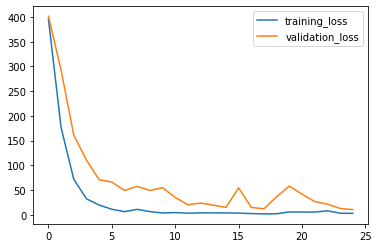

In [ ]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

In [ ]:
base_network.save('base_network_final.h5')